<a href="https://colab.research.google.com/github/shanksghub/Minute-by-Minute-Price-prediction/blob/master/Scrapped%20and%20%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas_datareader.data as web
import os
import datetime
import time

def download_data(tickers,start,end,all_data=False):
    count = 1
    if all_data==True:
        end = datetime.datetime.now()
        end = '%s-%s-%s' % (end.month,end.day,end.year)
        start = '01-01-1970'

    directory = 'stock_data'
    if not os.path.exists(directory):
        os.makedirs(directory)

    d = {}
    for ticker in tickers:
        filename = directory+'/'+ticker+'.csv'
        d[ticker] = web.DataReader(ticker,"yahoo",start,end)
        d[ticker].to_csv(filename)
        count  = count + 1
        if count % 50 == 0:
            time.sleep(10)
    return

if __name__ == '__main__':
    tickers = ['AAPL','BAC','GILD','MSFT']
    start = '2016-01-01'
    end = '2016-11-21'
    download_data(tickers,start,end,all_data=True)

6535 3220
Epoch 1/100
 - 1s - loss: 1.5355e-04
Epoch 2/100
 - 0s - loss: 1.0926e-04
Epoch 3/100
 - 0s - loss: 8.2029e-05
Epoch 4/100
 - 0s - loss: 5.9345e-05
Epoch 5/100
 - 0s - loss: 4.0018e-05
Epoch 6/100
 - 0s - loss: 2.4310e-05
Epoch 7/100
 - 0s - loss: 1.3315e-05
Epoch 8/100
 - 0s - loss: 6.2845e-06
Epoch 9/100
 - 0s - loss: 2.5407e-06
Epoch 10/100
 - 0s - loss: 9.8838e-07
Epoch 11/100
 - 0s - loss: 4.5654e-07
Epoch 12/100
 - 0s - loss: 3.1218e-07
Epoch 13/100
 - 0s - loss: 2.8181e-07
Epoch 14/100
 - 0s - loss: 2.7783e-07
Epoch 15/100
 - 0s - loss: 2.7595e-07
Epoch 16/100
 - 0s - loss: 2.7592e-07
Epoch 17/100
 - 0s - loss: 2.7638e-07
Epoch 18/100
 - 0s - loss: 2.7604e-07
Epoch 19/100
 - 0s - loss: 2.7614e-07
Epoch 20/100
 - 0s - loss: 2.7480e-07
Epoch 21/100
 - 0s - loss: 2.7483e-07
Epoch 22/100
 - 0s - loss: 2.7708e-07
Epoch 23/100
 - 0s - loss: 2.7468e-07
Epoch 24/100
 - 0s - loss: 2.7569e-07
Epoch 25/100
 - 0s - loss: 2.7429e-07
Epoch 26/100
 - 0s - loss: 2.7469e-07
Epoch 27/10

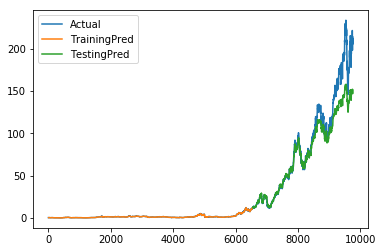

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



url1 = 'https://raw.githubusercontent.com/shanksghub/Minute-by-Minute-Price-prediction/master/AAPL.csv'


# import dataset 
df = pd.read_csv(url1)



df.head()
df =df.drop(columns=['Volume' ,'Adj Close'])

df.head()

df = df[['High']]


dataset = df.values
dataset = dataset.astype('float32')

dataset


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

trainX


trainY

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(df['High'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='TrainingPred')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='TestingPred')
plt.legend(loc='best')
plt.show()

6535 3220
Epoch 1/100
 - 1s - loss: 1.1577e-04
Epoch 2/100
 - 0s - loss: 8.6296e-05
Epoch 3/100
 - 0s - loss: 6.8803e-05
Epoch 4/100
 - 0s - loss: 5.3760e-05
Epoch 5/100
 - 0s - loss: 4.0556e-05
Epoch 6/100
 - 0s - loss: 2.8195e-05
Epoch 7/100
 - 0s - loss: 1.7803e-05
Epoch 8/100
 - 0s - loss: 9.6193e-06
Epoch 9/100
 - 0s - loss: 4.4507e-06
Epoch 10/100
 - 0s - loss: 1.8213e-06
Epoch 11/100
 - 0s - loss: 7.8583e-07
Epoch 12/100
 - 0s - loss: 4.8358e-07
Epoch 13/100
 - 0s - loss: 4.1885e-07
Epoch 14/100
 - 0s - loss: 4.0866e-07
Epoch 15/100
 - 0s - loss: 4.0763e-07
Epoch 16/100
 - 0s - loss: 4.0700e-07
Epoch 17/100
 - 0s - loss: 4.0814e-07
Epoch 18/100
 - 0s - loss: 4.0687e-07
Epoch 19/100
 - 0s - loss: 4.0944e-07
Epoch 20/100
 - 0s - loss: 4.0601e-07
Epoch 21/100
 - 0s - loss: 4.0685e-07
Epoch 22/100
 - 0s - loss: 4.0690e-07
Epoch 23/100
 - 0s - loss: 4.0421e-07
Epoch 24/100
 - 0s - loss: 4.0436e-07
Epoch 25/100
 - 0s - loss: 4.0515e-07
Epoch 26/100
 - 0s - loss: 4.0352e-07
Epoch 27/10

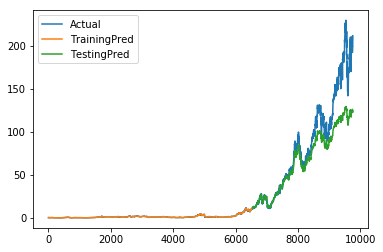

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



url1 = 'https://raw.githubusercontent.com/shanksghub/Minute-by-Minute-Price-prediction/master/AAPL.csv'


# import dataset 
df = pd.read_csv(url1)



df.head()
df =df.drop(columns=['Volume' ,'Adj Close'])

df.head()

df = df[['Low']]


dataset = df.values
dataset = dataset.astype('float32')

dataset


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

trainX


trainY

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(df['Low'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='TrainingPred')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='TestingPred')
plt.legend(loc='best')
plt.show()

6535 3220
Epoch 1/100
 - 1s - loss: 6.6925e-05
Epoch 2/100
 - 0s - loss: 3.5458e-05
Epoch 3/100
 - 0s - loss: 1.7885e-05
Epoch 4/100
 - 0s - loss: 7.4981e-06
Epoch 5/100
 - 0s - loss: 2.7247e-06
Epoch 6/100
 - 0s - loss: 1.0093e-06
Epoch 7/100
 - 0s - loss: 5.8614e-07
Epoch 8/100
 - 0s - loss: 5.1885e-07
Epoch 9/100
 - 0s - loss: 5.1551e-07
Epoch 10/100
 - 0s - loss: 5.1094e-07
Epoch 11/100
 - 0s - loss: 5.1116e-07
Epoch 12/100
 - 0s - loss: 5.1240e-07
Epoch 13/100
 - 0s - loss: 5.0962e-07
Epoch 14/100
 - 0s - loss: 5.0677e-07
Epoch 15/100
 - 0s - loss: 5.0657e-07
Epoch 16/100
 - 0s - loss: 5.0453e-07
Epoch 17/100
 - 0s - loss: 5.0592e-07
Epoch 18/100
 - 0s - loss: 5.0559e-07
Epoch 19/100
 - 0s - loss: 5.0206e-07
Epoch 20/100
 - 0s - loss: 5.0014e-07
Epoch 21/100
 - 0s - loss: 4.9967e-07
Epoch 22/100
 - 0s - loss: 5.0779e-07
Epoch 23/100
 - 0s - loss: 5.0233e-07
Epoch 24/100
 - 0s - loss: 4.9507e-07
Epoch 25/100
 - 0s - loss: 4.9811e-07
Epoch 26/100
 - 0s - loss: 4.9767e-07
Epoch 27/10

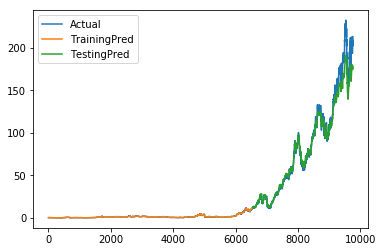

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



url1 = 'https://raw.githubusercontent.com/shanksghub/Minute-by-Minute-Price-prediction/master/AAPL.csv'


# import dataset 
df = pd.read_csv(url1)



df.head()
df =df.drop(columns=['Volume' ,'Adj Close'])

df.head()

df = df[['Close']]


dataset = df.values
dataset = dataset.astype('float32')

dataset


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

trainX


trainY

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='TrainingPred')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='TestingPred')
plt.legend(loc='best')
plt.show()

6535 3220
Epoch 1/100
 - 1s - loss: 7.0991e-05
Epoch 2/100
 - 0s - loss: 4.7760e-05
Epoch 3/100
 - 0s - loss: 3.2751e-05
Epoch 4/100
 - 0s - loss: 2.0208e-05
Epoch 5/100
 - 0s - loss: 1.0932e-05
Epoch 6/100
 - 0s - loss: 5.0552e-06
Epoch 7/100
 - 0s - loss: 2.0847e-06
Epoch 8/100
 - 0s - loss: 9.5688e-07
Epoch 9/100
 - 0s - loss: 6.7143e-07
Epoch 10/100
 - 0s - loss: 6.2496e-07
Epoch 11/100
 - 0s - loss: 6.1639e-07
Epoch 12/100
 - 0s - loss: 6.1398e-07
Epoch 13/100
 - 0s - loss: 6.1735e-07
Epoch 14/100
 - 0s - loss: 6.1201e-07
Epoch 15/100
 - 0s - loss: 6.1273e-07
Epoch 16/100
 - 0s - loss: 6.0902e-07
Epoch 17/100
 - 0s - loss: 6.0967e-07
Epoch 18/100
 - 0s - loss: 6.0931e-07
Epoch 19/100
 - 0s - loss: 6.1058e-07
Epoch 20/100
 - 0s - loss: 6.0695e-07
Epoch 21/100
 - 0s - loss: 6.0628e-07
Epoch 22/100
 - 0s - loss: 6.0947e-07
Epoch 23/100
 - 0s - loss: 6.0226e-07
Epoch 24/100
 - 0s - loss: 6.0306e-07
Epoch 25/100
 - 0s - loss: 6.0277e-07
Epoch 26/100
 - 0s - loss: 6.0089e-07
Epoch 27/10

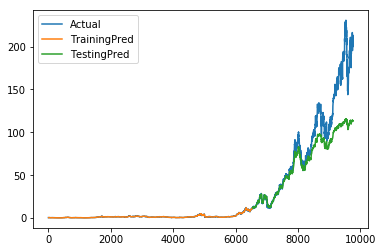

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



url1 = 'https://raw.githubusercontent.com/shanksghub/Minute-by-Minute-Price-prediction/master/AAPL.csv'


# import dataset 
df = pd.read_csv(url1)



df.head()
df =df.drop(columns=['Volume' ,'Adj Close'])

df.head()

df = df[['Open']]


dataset = df.values
dataset = dataset.astype('float32')

dataset


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

trainX


trainY

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(df['Open'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='TrainingPred')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='TestingPred')
plt.legend(loc='best')
plt.show()